In [1]:
import os
import time

import jax
import jax.numpy as jnp
from jax import jit, vmap, jacrev
from jax.tree_util import tree_map

import ml_collections
from absl import logging
import wandb
import matplotlib.pyplot as plt
import seaborn as sns

from jaxpi.samplers import UniformSampler
from jaxpi.utils import save_checkpoint, restore_checkpoint, flatten_pytree, jacobian_fn

import models
from utils import get_dataset

from configs import plain

W0000 00:00:1735722990.663312 15191240 mps_client.cc:510] WARNING: JAX Apple GPU support is experimental and not all JAX functionality is correctly supported!
I0000 00:00:1735722990.673625 15191240 service.cc:145] XLA service 0x174c84600 initialized for platform METAL (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1735722990.673644 15191240 service.cc:153]   StreamExecutor device (0): Metal, <undefined>
I0000 00:00:1735722990.675102 15191240 mps_client.cc:406] Using Simple allocator.
I0000 00:00:1735722990.675112 15191240 mps_client.cc:384] XLA backend will use up to 17179410432 bytes on device 0 for SimpleAllocator.


Metal device set to: Apple M4 Pro

systemMemory: 24.00 GB
maxCacheSize: 8.00 GB



In [2]:
# Import config
config = plain.get_config()

In [3]:
# Problem setup
T = 2.0  # final time
L = 2 * jnp.pi  # length of the domain
c = 50  # advection speed
n_t = 200  # number of time steps
n_x = 128  # number of spatial points

# Get  dataset
u_ref, t_star, x_star = get_dataset(T, L, c, n_t, n_x)
u0 = u_ref[0, :]

In [4]:
# Define domain
t0 = t_star[0]
t1 = t_star[-1]

x0 = x_star[0]
x1 = x_star[-1]

dom = jnp.array([[t0, t1],
                 [x0, x1]])

# Initialize residual sampler
res_sampler = iter(UniformSampler(dom, config.training.batch_size_per_device))

In [5]:
# Initialize model
model = models.Advection(config, u0, t_star, x_star, c)

In [6]:
# Restore model paramteres
workdir = '.'
ckpt_path = os.path.join(workdir, 'ckpt', config.wandb.name)
model.state = restore_checkpoint(model.state, ckpt_path)
params = model.state.params

In [7]:
# Compute L2 error
l2_error = model.compute_l2_error(params, u_ref)
print('L2 error: {:.3e}'.format(l2_error))

L2 error: 1.071e+00


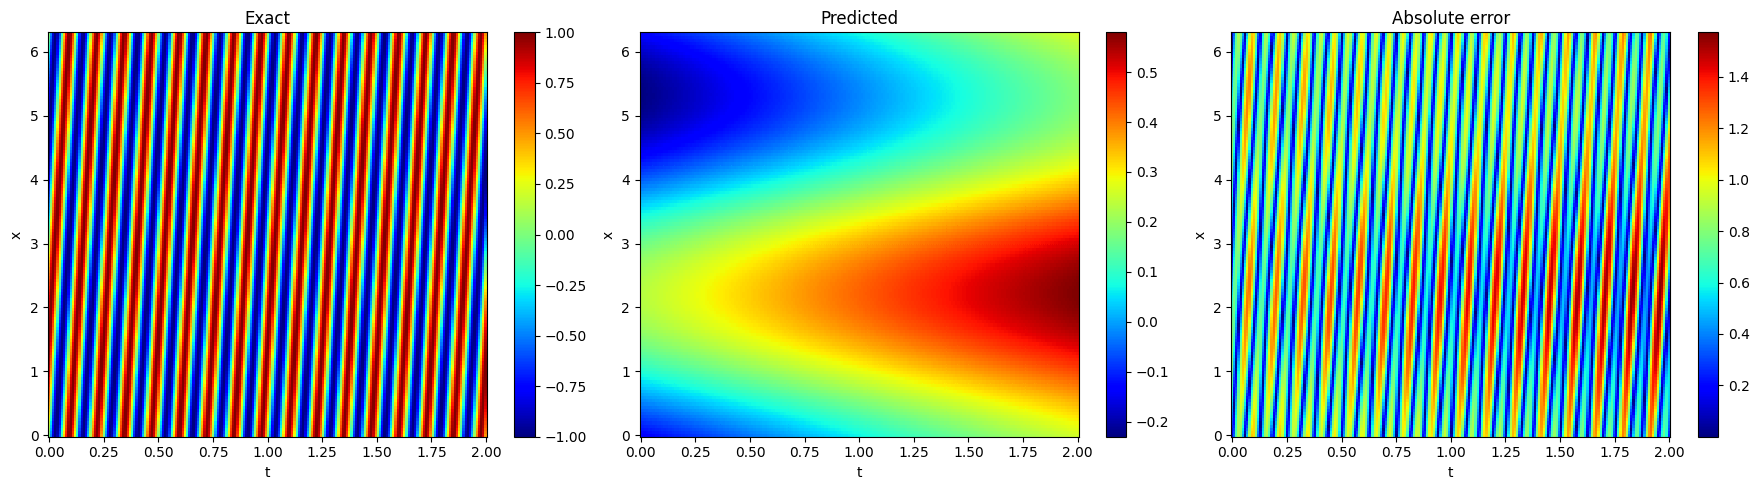

In [8]:
# Prediction
u_pred = model.u_pred_fn(params, model.t_star, model.x_star)
TT, XX = jnp.meshgrid(t_star, x_star, indexing='ij')

# Plot results
fig = plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
plt.pcolor(TT, XX, u_ref, cmap='jet')
plt.colorbar()
plt.xlabel('t')
plt.ylabel('x')
plt.title('Exact')
plt.tight_layout()

plt.subplot(1, 3, 2)
plt.pcolor(TT, XX, u_pred, cmap='jet')
plt.colorbar()
plt.xlabel('t')
plt.ylabel('x')
plt.title('Predicted')
plt.tight_layout()

plt.subplot(1, 3, 3)
plt.pcolor(TT, XX, jnp.abs(u_ref - u_pred), cmap='jet')
plt.colorbar()
plt.xlabel('t')
plt.ylabel('x')
plt.title('Absolute error')
plt.tight_layout()

# Visualize gradients

In [9]:
# Load first checkpoint 
model.state = restore_checkpoint(model.state, ckpt_path, step=10000)
params = model.state.params

ValueError: Matching checkpoint not found: ckpt/plain/checkpoint_10000

In [68]:
# Get a random batch
batch = next(res_sampler)
batch = jax.device_get(tree_map(lambda x: x[0], batch))

In [69]:
# Compute gradient of each loss with respect to network parameters
grads = jacrev(model.losses)(params, batch)

grad_dict = {}
for key, value in grads.items():
    flattened_grad = flatten_pytree(value)
    grad_dict[key] = flattened_grad

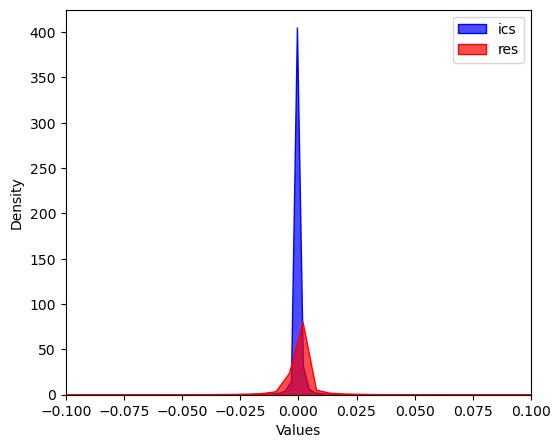

In [71]:
# Plot gradients as histograms
fig = plt.figure(figsize=(6, 5))

sns.kdeplot(grad_dict['ics'], shade=True, alpha=0.7, color='blue', label='ics')
sns.kdeplot(grad_dict['res'], shade=True, alpha=0.7, color='red', label='res')

plt.xlabel('Values')
plt.ylabel('Density')
plt.xlim([-0.1, 0.1])
plt.legend()
plt.show()

# Visualize NTK

In [22]:
def compute_jacobian(params, batch):
    ics_jacobian = vmap(jacobian_fn, (None, None, None, 0))(model.u_net, params, model.t0, model.x_star)
    res_jacobian = vmap(jacobian_fn, (None, None, 0, 0))(model.r_net, params, batch[:, 0], batch[:, 1])
    
    jacobian_dict = {'ics': ics_jacobian, 'res': res_jacobian}
    
    return jacobian_dict


def compute_full_ntk(params, batch):
    jacobian_dict = compute_jacobian(params, batch)
    
    ntk_dict = {}
    for key, values in jacobian_dict.items():
        ntk_dict[key] = values @ values.T

    return ntk_dict

In [44]:
# Compute full NTK matrix
ntk_dict = compute_full_ntk(params, batch)

# Compute eigenvalue of each NTK
eigval_dict = {}
for key, values in ntk_dict.items():
    eigval, eigvec = jnp.linalg.eigh (values)
    eigval_dict[key] = eigval

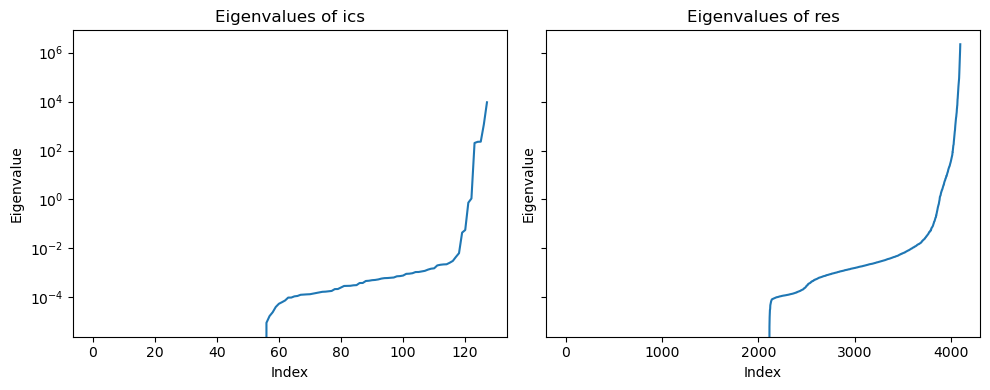

In [55]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4),  sharey=True)

# Plot eigenvalues for 'ics'
ax1.plot(eigval_dict['ics'])
ax1.set_title('Eigenvalues of ics')
ax1.set_xlabel('Index')
ax1.set_ylabel('Eigenvalue')
ax1.set_yscale('log')

# Plot eigenvalues for 'res'
ax2.plot(eigval_dict['res'])
ax2.set_title('Eigenvalues of res')
ax2.set_xlabel('Index')
ax2.set_ylabel('Eigenvalue')
ax2.set_yscale('log')

plt.tight_layout()
plt.show()

# Visualize temporal residuals

In [142]:
@jit 
def compute_temporal_residuals(params, batch):
    # Sort temporal coordinates for computing  temporal weights
    t_sorted = batch[:, 0].sort()
    # Compute residuals over the full domain
    r_pred = vmap(model.r_net, (None, 0, 0))(params, t_sorted, batch[:, 1])
    # Split residuals into chunks
    r_pred = r_pred.reshape(config.weighting.num_chunks, -1)
    res = jnp.mean(r_pred ** 2, axis=1)
    return res

In [152]:
t = jnp.linspace(t0, t1, config.weighting.num_chunks)

temporal_residuals = compute_temporal_residuals(params, batch)

Text(0, 0.5, '$L_r$')

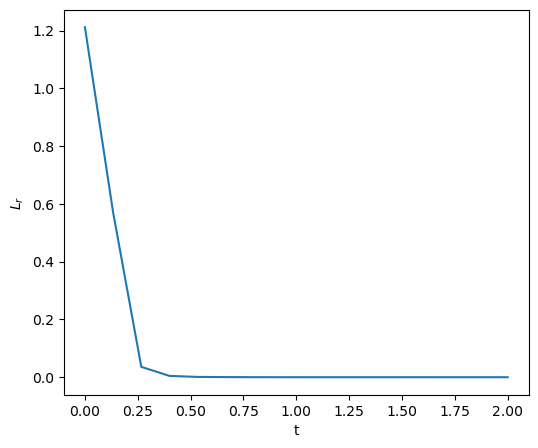

In [154]:
plt.figure(figsize=(6, 5))

plt.plot(t, temporal_residuals)

plt.xlabel('t')
plt.ylabel('$L_r$')